## Optimization & Training(Exper)
- 텐서플로우 공식 홈페이지에서 말한 expert한 방법

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import datasets
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras import Model
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Preprocess
- tf.data사용하여 mnist data load
- Conv2D의 input_shape 타입으로 만추기 위해 차원 추가
- Data Normalization

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0 # Normalization

# 채널 차원을 추가합니다.
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

### tf.data

In [3]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(1000) #버퍼사이즈
train_ds = train_ds.batch(32) # 배치사이즈 만큼 데이터가 나온다.

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(32)

## Build Model

In [12]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(input_shape=(28, 28, 1), filters=32, kernel_size=(3,3), strides=(1, 1), padding='SAME', activation='relu')
    self.maxpool1 = MaxPooling2D([2, 2], padding='same')
    self.dropout1 = Dropout(0.25)
    
    self.conv2 = Conv2D(input_shape=(28, 28, 1), filters=32, kernel_size=(3,3), strides=(1, 1), padding='SAME', activation='relu')
    self.maxpool2 = MaxPooling2D([2, 2], padding='same')
    self.dropout2 = Dropout(0.25)
    
    self.flatten = Flatten()
    self.dense1 = Dense(512, activation='relu')
    self.dropout3 = Dropout(0.25)
    self.dense2 = Dense(10, activation='softmax')

  def call(self, x):
    x = self.conv1(x)
    x = self.maxpool1(x)
    x = self.dropout1(x)
    
    x = self.conv2(x)
    x = self.maxpool2(x)
    x = self.dropout2(x)
        
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dropout3(x)
    
    return self.dense2(x)

model = MyModel()

## Visualize Data
- matplotlib 이용하여 데이터 시각화하기
- train_ds.take(): 데이터 수를 제한할 수 있다.
- take(2): 전체 데이터 셋에서 2개만 가져온다.
- train_ds의 shape = (32(batch_size), 28(col), 28(row), 1(channel))

In [13]:
image, label = next(iter(train_ds))
image.shape, label.shape

(TensorShape([32, 28, 28, 1]), TensorShape([32]))

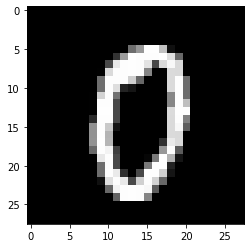

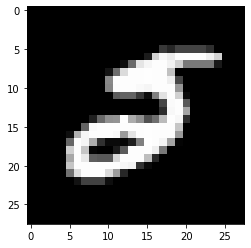

In [14]:
for image, label in train_ds.take(2):
#     plt.title(""+label[0])
    plt.imshow(image[0, :, :, 0], 'gray') #32개중 첫번째만 가져온다
    plt.show()

## Training(Keras)
Keras로 학습할 때는 기존과 같지만, train_ds는 generator라서 그대로 넣을 수 있음

## Optimization
- Loss Function
- Optimizer

In [25]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

- 모델의 손실과 성능을 측정할 지표를 선택합니다. 에포크가 진행되는 동안 수집된 측정 지표를 바탕으로 최종 결과를 출력합니다.
- epoch 마다 mean을 사용하면, epoch마다 좀 더 부드럽게 나타낼수있다.

In [27]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

## Training
- @tf.function - 기존 session 열었던 것처럼 바로 작동 안 하고, 그래프만 만들고 학습이 시작되면 돌아가도록 함
- tf.GradientTape를 사용하여 모델을 훈련합니다:

In [17]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    # optimizer를 통해 모델에 업데이트 한다.
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, predictions)

In [18]:
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)
    
    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [19]:
EPOCHS = 1

for epoch in range(EPOCHS):
    for images, labels in train_ds:
        train_step(images, labels)
    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
        
    template = 'Epoch: {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         test_loss.result(),
                         test_accuracy.result()*100))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch: 1, Loss: 0.11881478130817413, Accuracy: 96.27166748046875, Test Loss: 0.05459275841712952, Test Accuracy: 98.05999755859375


In [24]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    print("init")

  def call(self, x):
    print("call")
  
  def call2(self):
    print("call2")

    
model = MyModel()
model('a')
model('a')
model.call2()

init
call
call
call2
